# Models training
In this notebook we train and analyze multiple models, compare them and tune them to get the best results. We will work with a small subset due to low hardware availability.

# 1.0 Unsupervised
We first try and distinguish the words without letting the model know the labels.

# 1.1 Dynamic Time Wrapping and KMeans (DTW)

In [17]:
# After Kernel restart you can sgtart here.
import pandas as pd
import os
import numpy as np
import pickle
from collections import Counter

with open('landmarks_subset_proccessed.pkl', 'rb') as file:
    subset_landmarks = pickle.load(file)

data_info = pd.read_csv('video_labels.csv',dtype={'video_id': object})
subset_words = ['tall', 'man', 'red', 'shirt', 'play', 'basketball', 'cold', 'pizza', 'top', 'cheese', 'taste',
                'delicious', 'lazy', 'afternoon', 'dark', 'room', 'small', 'lamp', 'empty',
                'big', 'dog', 'walk', 'beautiful', 'every', 'morning', 'short',
                'woman', 'wear', 'dress', 'have', 'beautiful', 'daughter']

POSE = np.hstack((np.ones(33), np.zeros(21+21+468))) == 1
LH = np.hstack((np.zeros(33), np.ones(21), np.zeros(21+468))) == 1
RH = np.hstack((np.zeros(33+21), np.ones(21), np.zeros(468))) == 1
FACE = np.hstack((np.zeros(33+21+21), np.ones(468))) == 1
videos_per_word = Counter(data_info.loc[data_info.word.isin(subset_words),'word'])

# Trying with Classifier

In [18]:
train_signer_id = pd.array([118, 31, 59, 11, 115, 94, 6, 21, 10, 38, 56, 41, 4, 45, 32, 46, 13, 42, 39, 17, 89, 60, 35, 15, 3, 92, 93, 34, 107, 28, 99, 37, 8, 97, 70, 19, 91, 106, 63, 29, 26, 117, 66, 119, 50, 103, 120, 95, 78, 27, 108, 57, 53, 75, 104, 43, 40, 77, 1, 33, 22, 105, 48, 73, 23])
test_signer_id = pd.array([2, 52, 12, 98, 88])
validation_signer_id = pd.array([59, 115, 90, 4, 116, 100, 101, 102, 96, 90, 36])

train_set = data_info[data_info["signer_id"].isin(train_signer_id)]
test_set = data_info[data_info["signer_id"].isin(test_signer_id)]
val_set = data_info[data_info["signer_id"].isin(validation_signer_id)]

train_subset = train_set[train_set["word"].isin(subset_words)]
test_subset = test_set[test_set["word"].isin(subset_words)]
val_subset = val_set[val_set["word"].isin(subset_words)]


In [28]:
averaged = {}
x = 0
for video in subset_landmarks.keys():
    x = x + 1
    averaged[video] = subset_landmarks[video][:, LH+RH+POSE, :].mean(axis=0).flatten()



In [80]:
averaged_pd.head

<bound method NDFrame.head of     video_id         0         1         2         3         4         5  \
0      62175  0.425838  0.218913 -1.234384  0.449388  0.185427 -1.171990   
1      62159  0.412828  0.210151 -0.951068  0.437871  0.172065 -0.896456   
2      62160  0.576500  0.282573 -1.076096  0.604648  0.235077 -1.014963   
3      62163  0.507248  0.271957 -1.239369  0.535961  0.225712 -1.173363   
4      62164  0.417331  0.256031 -1.266485  0.447800  0.210131 -1.184287   
..       ...       ...       ...       ...       ...       ...       ...   
269    19049  0.316342  0.197806 -0.766256  0.337244  0.157780 -0.719825   
270    19051  0.569007  0.269934 -1.521104  0.604298  0.227050 -1.451669   
271    19054  0.434736  0.232866 -0.802858  0.455187  0.198367 -0.763336   
272    32097  0.395933  0.235503 -1.205327  0.412346  0.198697 -1.146361   
273    32094  0.338070  0.195371 -0.766534  0.358131  0.156594 -0.721856   

            6         7         8         9        10    

In [54]:
averaged_pd = pd.DataFrame(averaged).T
averaged_pd = averaged_pd.rename_axis('video_id')
averaged_pd = averaged_pd.reset_index()
averaged_pd["video_id"]

0      62175
1      62159
2      62160
3      62163
4      62164
       ...  
269    19049
270    19051
271    19054
272    32097
273    32094
Name: video_id, Length: 274, dtype: object

In [72]:
train_subset_pd = pd.merge(train_subset, averaged_pd, on='video_id', how='left')
test_subset_pd = pd.merge(test_subset, averaged_pd, on='video_id', how='left')
val_subset_pd = pd.merge(val_subset, averaged_pd, on='video_id', how='left')


In [83]:
## Logistic Regression

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Separate features and labels
X_train = train_subset_pd.loc[:, 0:224]
y_train = train_subset_pd["word"]

X_test = val_subset_pd.loc[:, 0:224]
y_test = val_subset_pd["word"]

# Create a logistic regression model
model = LogisticRegression(max_iter=200)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{classification_rep}')

Accuracy: 0.42
Confusion Matrix:
[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 1 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labe

In [85]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Create an SVM classifier
svm_classifier = SVC(kernel='nonlinear', C=1.0)

# Train the classifier on the training data
svm_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = svm_classifier.predict(X_test)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("\nClassification Report:")
print(report)

InvalidParameterError: The 'kernel' parameter of SVC must be a str among {'sigmoid', 'poly', 'precomputed', 'linear', 'rbf'} or a callable. Got 'nonlinear' instead.

In [86]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Create a RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the training data
rf_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_classifier.predict(X_test)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("\nClassification Report:")
print(report)

Accuracy: 0.54

Classification Report:
              precision    recall  f1-score   support

   afternoon       0.50      1.00      0.67         1
  basketball       0.12      1.00      0.22         1
   beautiful       0.00      0.00      0.00         0
         big       1.00      0.25      0.40         4
      cheese       1.00      1.00      1.00         3
        cold       1.00      0.67      0.80         3
        dark       1.00      0.75      0.86         8
    daughter       1.00      0.67      0.80         3
   delicious       0.00      0.00      0.00         1
         dog       0.00      0.00      0.00         2
       empty       1.00      1.00      1.00         1
       every       0.50      1.00      0.67         1
        have       0.00      0.00      0.00         0
        lazy       0.00      0.00      0.00         1
         man       0.60      0.75      0.67         4
     morning       0.00      0.00      0.00         1
       pizza       0.20      1.00      0.3

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_cla

## 3.1 Sainity chack with DTW
Dynamic Time Wrapping can detect similar motions but its computation is slow, let's take videos of two words only, without the face (which has the majority of landmarks) and check whether it is a good approach.

In [ ]:
words = ["play","basketball","morning","tall","dress","beautiful"]
for word in words:
    print(word, videos_per_word[word])

dtw_landmarks = {}
for word in words:
    videos = data_info.loc[data_info.word==word,'video_id']
    for vid in videos[:2]:
        dtw_landmarks[vid] = subset_landmarks[vid][::3,POSE+LH+RH,:] # Exclude augmented videos for now
len(dtw_landmarks)

play 11
basketball 12
morning 6
tall 13
dress 8


10

/Users/oren/anaconda3/envs/ai/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


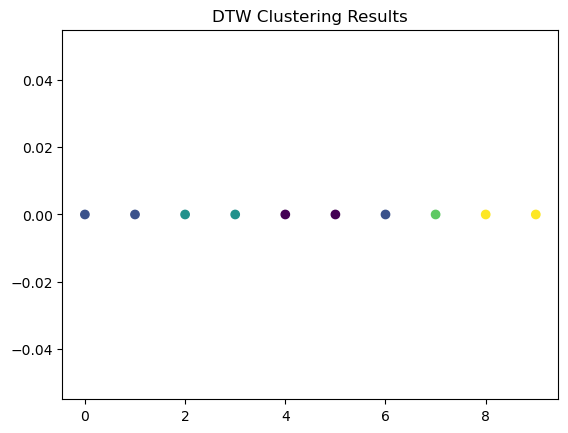

['play', 'basketball', 'morning', 'tall', 'dress']


In [ ]:
import numpy as np
from fastdtw import fastdtw
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Function to compute DTW distance between two sequences
def dtw_distance(seq1, seq2):
    distance, path = fastdtw(seq1, seq2)
    return distance

# Function to perform clustering using DTW
def dtw_cluster(video_landmarks, num_clusters):
    # Flatten the video landmarks into sequences
    sequences = [frame.flatten() for frame in video_landmarks]

    # Compute pairwise DTW distances
    num_frames = len(video_landmarks)
    distances = np.zeros((num_frames, num_frames))
    for i in range(num_frames):
        for j in range(i + 1, num_frames):
            distances[i, j] = dtw_distance(sequences[i], sequences[j])
            distances[j, i] = distances[i, j]

    # Perform KMeans clustering based on DTW distances
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    labels = kmeans.fit_predict(distances)

    return labels

# Example usage
# Assuming 'video_landmarks' is a list of 2D arrays representing landmarks for each frame
# You can adjust 'num_clusters' based on your requirements
num_clusters = len(words)
cluster_labels = dtw_cluster(dtw_landmarks.values(), num_clusters)

# Visualize the clustering results
plt.scatter(range(len(dtw_landmarks)), [0] * len(dtw_landmarks), c=cluster_labels, cmap='viridis')
plt.title('DTW Clustering Results')
plt.show()
print(words)